In [296]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")

## Theoretical $q^2$

In [297]:
def dGammaJpsimu(q2):
    return 6.79842*10**(-7) * (0. + (1 + 0.0055125/q2) * ((4.31066 * np.exp(0.038 * q2 + 0.0015 * q2**2) - 0.0448191 * np.exp(0.065 * q2 + 0.0015* q2**2)*np.sqrt((10.106 - q2) * (87.8156 - q2)))**2 + \
            (4.31066 *np.exp(0.038 *q2 + 0.0015 *q2**2) + 0.0448191 *np.exp(0.065* q2 + 0.0015 *q2**2)*np.sqrt((10.106 - q2)* (87.8156 - q2)))**2 \
            + (2.29039* (0.007288 *np.exp(0.064 * q2 + 0.0041* q2**2)* (10.106 - q2)* (87.8156 - q2) + 0.46 *np.exp(0.038 *q2 + 0.0015 *q2**2) *(-29.7904 + q2))**2)/q2) + \
            (0.0057567 *np.exp(0.094 *q2 + 0.0034 *q2**2) *(10.106 - q2) *(87.8156 - q2))/q2**2)*(1 - 0.011025/q2)**2 *np.sqrt((10.106 - q2) *(87.8156 - q2))* q2


def dGammaJpsitau(q2):
    return 6.79842*10**(-7) * (0. + (1 + 1.58064/q2) * ((4.31066 *np.exp(0.038 *q2 + 0.0015* q2**2) - 0.0448191 *np.exp(0.065* q2 + 0.0015 *q2**2)* np.sqrt((10.106 - q2) *(87.8156 - q2)))**2 +\
            (4.31066 *np.exp(0.038 *q2 + 0.0015 *q2**2) +0.0448191 *np.exp(0.065* q2 + 0.0015 *q2**2)*np.sqrt((10.106 - q2)* (87.8156 - q2)))**2 \
            + (2.29039* (0.007288 *np.exp(0.064 *q2 + 0.0041 *q2**2)* (10.106 - q2)* (87.8156 - q2) + 0.46*np.exp(0.038 *q2 + 0.0015 *q2**2) *(-29.7904 + q2))**2)/q2) + \
            (1.65066 *np.exp(0.094* q2 + 0.0034 *q2**2)* (10.106 - q2) *(87.8156 - q2))/q2**2)* (1 - 3.16128/q2)**2 *np.sqrt((10.106 - q2) *(87.8156 - q2))* q2

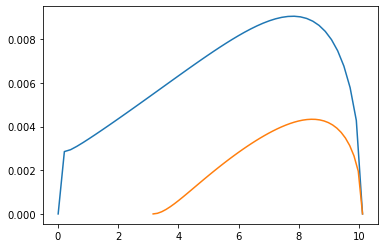

In [298]:
q2_mu = np.linspace(0.105**2, 10.106)
q2_tau = np.linspace(1.778**2, 10.106)

dGmu = dGammaJpsimu(q2_mu)
dGtau = dGammaJpsitau(q2_tau)

plt.plot(q2_mu, dGmu)
plt.plot(q2_tau, dGtau)

## Loading Data

In [299]:
epsilon_pimu = 1/100

# No veto
modes_dt = {0: {'mode': './features/JpsiTauNu_10Noise_NoVeto.root', 'yields': 3.76e3}, 
            1: {'mode': './features/JpsiMuNu_10Noise_NoVeto.root', 'yields': 1.03e5},
            2: {'mode': './features/RJpsiInclusive_10Noise_NoVeto.root', 'yields': 3.83e3},
            3: {'mode': './features/RJpsiCombCascade_10Noise_NoVeto.root', 'yields': 7.89e4},
            4: {'mode': './features/RJpsiMisID_10Noise_NoVeto.root', 'yields': epsilon_pimu*1.10e8}
           }



# # 20noise
# modes_dt = {0: {'mode': './features/JpsiTauNu_20Noise_NoVeto.root', 'yields': 3.65e3}, 
#             1: {'mode': './features/JpsiMuNu_20Noise_NoVeto.root', 'yields': 9.95e4},
#             2: {'mode': './features/RJpsiInclusive_20Noise_NoVeto.root', 'yields': 3.79e3},
#             3: {'mode': './features/RJpsiCombCascade_20Noise_NoVeto.root', 'yields': 7.94e4},
#             4: {'mode': './features/RJpsiMisID_20Noise_NoVeto.root', 'yields': epsilon_pimu*1.10e8}
#            }

In [300]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        print('\rReading:', i)
        file = uproot.open(v['mode'])
#         df_i = file['t'].pandas.df()
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        
        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
#         print(len(idx))
        idx = idx[:20000]    # if too much data
#         idx = idx[:5000]    # if too much data
        num_lt.append(len(idx))    

        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(idx)
        print(df_i['weight'][0])
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [301]:
tr_te_split = 0.5
df_train, df_test = load_train_test(modes_dt, tr_te_split)
# make a copy
df_train_o, df_test_o = df_train.copy(), df_test.copy()

Reading: 0
1.8458517427589594
Reading: 1
19.548301385462135
Reading: 2
22.662721893491124
Reading: 3
44.325842696629216
Reading: 4
55.0
train size: 14629 (50.01%); test size: 14626 (49.99%)
data points per mode:  [2037, 5269, 169, 1780, 20000]


In [302]:
file = uproot.open("./features/JpsiTauNu_FWM.root")
# df_tau = file['t'].pandas.df()
df_tau = pd.DataFrame(np.array(file['t']['FWMs'].array()))
df_tau = df_tau.set_index('iEvt')

file = uproot.open("./features/JpsiMuNu_FWM.root")
df_mu = pd.DataFrame(np.array(file['t']['FWMs'].array()))
df_mu = df_mu.set_index('iEvt')

file = uproot.open("./features/RJpsiMisID_FWM.root")
df_misid = pd.DataFrame(np.array(file['t']['FWMs'].array()))
df_misid = df_misid.set_index('iEvt')

file = uproot.open("./features/RJpsiInclusive_FWM.root")
df_incl1 = pd.DataFrame(np.array(file['t']['FWMs'].array()))
df_incl1 = df_incl1.set_index('iEvt')

file = uproot.open("./features/RJpsiInclusive_FWM_seed2.root")
df_incl2 = pd.DataFrame(np.array(file['t']['FWMs'].array()))
df_incl2 = df_incl2.set_index('iEvt')
df_incl = pd.concat([df_incl1, df_incl2])

file = uproot.open("./features/RJpsiCombCascade_FWM.root")
df_comb = pd.DataFrame(np.array(file['t']['FWMs'].array()))
df_comb = df_comb.set_index('iEvt')

In [303]:
FWM_col = ['H_EE0', 'H_EE1', 'H_EE2', 'H_EE3', 'H_EE4', 
           'H_EE5', 'H_EE6', 'H_EE7', 'H_EE8', 'H_EE9', 'H_EE10']

In [304]:
df_train_o.loc[df_train_o.target==0, FWM_col] = df_tau.loc[df_train_o.loc[df_train_o.target==0]['iEvt']][FWM_col].values
df_train_o.loc[df_train_o.target==1, FWM_col] = df_mu.loc[df_train_o.loc[df_train_o.target==1]['iEvt']][FWM_col].values
df_train_o.loc[df_train_o.target==2, FWM_col] = df_incl.loc[df_train_o.loc[df_train_o.target==2]['iEvt']][FWM_col].values
df_train_o.loc[df_train_o.target==3, FWM_col] = df_comb.loc[df_train_o.loc[df_train_o.target==3]['iEvt']][FWM_col].values
df_train_o.loc[df_train_o.target==4, FWM_col] = df_misid.loc[df_train_o.loc[df_train_o.target==4]['iEvt']][FWM_col].values


In [305]:
df_test_o.loc[df_test_o.target==0, FWM_col] = df_tau.loc[df_test_o.loc[df_test_o.target==0]['iEvt']][FWM_col].values
df_test_o.loc[df_test_o.target==1, FWM_col] = df_mu.loc[df_test_o.loc[df_test_o.target==1]['iEvt']][FWM_col].values
df_test_o.loc[df_test_o.target==2, FWM_col] = df_incl.loc[df_test_o.loc[df_test_o.target==2]['iEvt']][FWM_col].values
df_test_o.loc[df_test_o.target==3, FWM_col] = df_comb.loc[df_test_o.loc[df_test_o.target==3]['iEvt']][FWM_col].values
df_test_o.loc[df_test_o.target==4, FWM_col] = df_misid.loc[df_test_o.loc[df_test_o.target==4]['iEvt']][FWM_col].values


In [306]:
df_train = df_train_o.copy()
df_test = df_test_o.copy()

In [307]:
def relabel(x):
    if x == 0:    # tau
        return 0
    elif x == 1:    # mu
        return 1
    else:    # other bkg
        return 2

In [308]:
# relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [309]:
df_train.columns

Index(['iEvt', 'q2', 'miss2', 'pB', 'EB', 'pHc', 'EHc', 'pMu', 'EMu',
       'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 'mHcMu',
       'pPerp', 'pPerpHc', 'mCorr', 'D0Max', 'DzMax', 'D0Sum', 'DzSum',
       'ENeutral03', 'ENeutral06', 'ENeutral03Hadron', 'ENeutral06Hadron',
       'ENeutral03Photon', 'ENeutral06Photon', 'ECharge03', 'ECharge06',
       'ECharge03PV', 'ECharge06PV', 'ECharge03DV', 'ECharge06DV', 'mK0SHcMu',
       'pK0S', 'q2True', 'miss2True', 'EBTrue', 'pBTrue', 'sMinMuHcVertTrue',
       'target', 'weight', 'H_EE0', 'H_EE1', 'H_EE2', 'H_EE3', 'H_EE4',
       'H_EE5', 'H_EE6', 'H_EE7', 'H_EE8', 'H_EE9', 'H_EE10'],
      dtype='object')

In [334]:
# features = ['q2', 'miss2', 
#             'pB', 'EB', 
#             'pHc', 'EHc', 
#             'pMu', 'EMu',
#             'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
#             'mHcMu',
#             'pPerp', 'mCorr', 
#             'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
#             'ENeutral03','ENeutral06', 
#             'ENeutral03Hadron', 'ENeutral06Hadron',
#             'ENeutral03Photon', 'ENeutral06Photon', 
#             'ECharge03', 'ECharge06',
#             'ECharge03PV', 'ECharge06PV', 
#             'ECharge03DV', 'ECharge06DV', 
#             'mK0SHcMu', 'pK0S'
#            ]

features = ['q2', 'miss2',  # check
            'pB', 'EB',  # check
            'pHc', 'EHc', # check 
            'pMu', 'EMu', # check
            'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc',  # check
            'mHcMu', # check
            'pPerp', 'mCorr',  # check
            'D0Max', 'DzMax', 'D0Sum', 'DzSum',  # check
            'ENeutral03','ENeutral06',  # check
            'ENeutral03Hadron', 'ENeutral06Hadron', # check
            'ENeutral03Photon', 'ENeutral06Photon',  # check
            'ECharge03', 'ECharge06', # check
            'ECharge03PV', 'ECharge06PV',  # check
            'ECharge03DV', 'ECharge06DV' # check
           ]

In [335]:
# Original + FWM
# features = features + FWM_col

# # Vertex + FWM
features = ['sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc'] + FWM_col

# # Vertex + Isolation + FWM
# features = ['sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc'] + \
#             ['ENeutral03','ENeutral06',  # check
#             'ENeutral03Hadron', 'ENeutral06Hadron', # check
#             'ENeutral03Photon', 'ENeutral06Photon',  # check
#             'ECharge03', 'ECharge06', # check
#             'ECharge03PV', 'ECharge06PV',  # check
#             'ECharge03DV', 'ECharge06DV' ] + FWM_col



features

['sMinMuHcVert',
 'sMinMuTr',
 'sMinHcTr',
 'sPVHc',
 'H_EE0',
 'H_EE1',
 'H_EE2',
 'H_EE3',
 'H_EE4',
 'H_EE5',
 'H_EE6',
 'H_EE7',
 'H_EE8',
 'H_EE9',
 'H_EE10']

In [336]:
df_train[features] = df_train[features].replace([99999, -np.inf, np.inf], np.nan)
df_test[features] = df_test[features].replace([99999, -np.inf, np.inf], np.nan)

In [337]:
# df_train_o[df_train_o.target==4]['pPerpHc']

## Reweight by $q^2
$

In [338]:
# replace some values that have q2 larger than the max, by the max
# df_train_o.loc[(df_train_o['q2True']>=11) & ((df_train_o.target==0) | (df_train_o.target==1)), 'q2True'] = 10.9
# df_train.loc[(df_train['q2True']>=11) & ((df_train.target==0) | (df_train.target==1)), 'q2True'] = 10.9
# df_test.loc[(df_test['q2True']>=11) & ((df_test.target==0) | (df_test.target==1)), 'q2True'] = 10.9

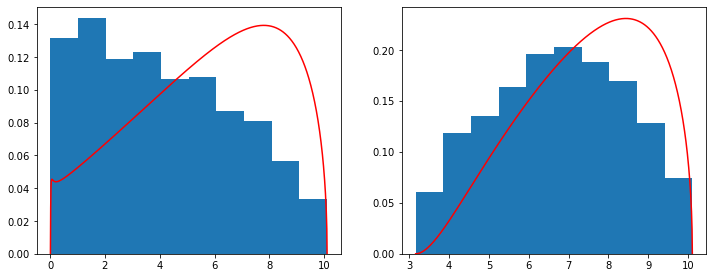

In [339]:
bins = 10

plt.figure(figsize=(12, 10))

# plot for mu
ax1 = plt.subplot(221)
range_mu = [0.105**2, 10.106]
ax1.hist(df_train_o[df_train_o.target==1]['q2True'], bins=bins, density=True, range=range_mu);
q2_mu = np.linspace(range_mu[0], range_mu[1], 1000, endpoint=True)
dGmu = dGammaJpsimu(q2_mu)
ax1.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

# plot for tau
ax2 = plt.subplot(222)
range_tau = [1.778**2, 10.106]
ax2.hist(df_train_o[df_train_o.target==0]['q2True'], bins=bins, density=True, range=range_tau);
q2_tau = np.linspace(range_tau[0], range_tau[1], 1000, endpoint=True)
dGtau = dGammaJpsitau(q2_tau)
ax2.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

In [340]:
# reweight according to q^2
def find_m_rw(dGamma, df_train, target, range_, bin_num=10):
    # get the truth q2 array
    q2 = df_train[df_train.target==target]['q2True'].values    

    # Simulated bins
    hist, bins = np.histogram(a=q2, bins=bin_num, density=True, range=range_)
    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2

    # Theoretical bins
    th_w = []
    for i in range(bin_num):
        dx = -(bins[i] - bins[i+1])/10
        x = np.linspace(bins[i], bins[i+1], 1000)
        y = dGamma(q2=x)
        th_w.append(np.trapz(y, dx=dx))    # Find area under curve
    # normalize
    th_w = th_w / sum(th_w) / width

    # reweighting
    m_rw = th_w / hist
    m_rw[np.isinf(m_rw)] = 0
    
    # return the values of each bin, and the bin bounds
    return m_rw, bins





# add the reweighting column to th dataframe
def add_m_rw(target, m_rw, bins, df):
    for i in range(len(bins)-1):
        df.loc[(df['target']==target) & (df['q2True']>=bins[i]) & (df['q2True']<bins[i+1]), 'm_rw'] = m_rw[i]
    
#     print(df.loc[df['target']==target, 'weight'].sum())
#     df.loc[df.target==target, 'm_rw'] = df.loc[df.target==target, 'm_rw']/(df.loc[df.target==target, 'm_rw'].sum())
    df.loc[df['target']==target, 'reweight'] = df.loc[df['target']==target, 'weight'] * df.loc[df.target==target, 'm_rw']
    df = df.drop(columns = ['m_rw'])
    
#     print(df.loc[df.target==target, 'reweight'].sum())
#     print()
    return df

In [341]:
# getting the weightings, and the bin bounds
m_rw_tau, bins_tau = find_m_rw(dGammaJpsitau, df_train_o, target=0, range_=range_tau)
m_rw_mu, bins_mu = find_m_rw(dGammaJpsimu, df_train_o, target=1, range_=range_mu)

# duplicate the column for inputting to the function to get the reweight column
df_train_o['reweight'] = df_train_o['weight']
df_train['reweight'] = df_train['weight']
df_test['reweight'] = df_test['weight']

df_train_o = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train_o)
df_train_o = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train_o)

df_train = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train)
df_train = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train)

df_test = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_test)
df_test = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_test)


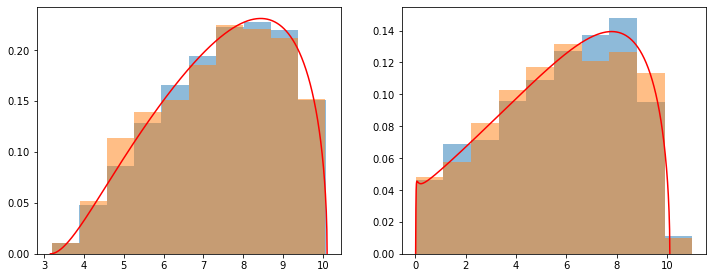

In [342]:
bins = 10

plt.figure(figsize=(12, 10))

# reweighted plot for tau, in testing 
ax1 = plt.subplot(221)
ax1.hist(df_train[df_train.target==0]['q2True'], bins=10, weights=df_train[df_train.target==0]['reweight'], density=True, alpha=0.5);
ax1.hist(df_test[df_test.target==0]['q2True'], bins=10, weights=df_test[df_test.target==0]['reweight'], density=True, alpha=0.5);
ax1.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

# reweighted plot for mu, in testing 
ax2 = plt.subplot(222)
ax2.hist(df_train[df_train.target==1]['q2True'], bins=10, weights=df_train[df_train.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.hist(df_test[df_test.target==1]['q2True'], bins=10, weights=df_test[df_test.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

## BDT

In [343]:
# getting the inputs and labels
X_train = df_train[features]
y_train = np.array(df_train.target)

# getting the inputs and labels
X_test = df_test[features]
y_test = np.array(df_train.target)

In [344]:
# trainging
X_train = df_train[features]
y_train = np.array([relabel(i) for i in df_train['target']])

# testing
X_test = df_test[features]
y_test = np.array([relabel(i) for i in df_test['target']])

# fitting, with reweighting
xgbc1 = xgb.XGBClassifier(seed=0)
xgbc1.fit(X_train, y_train, sample_weight=df_train.reweight.values);

In [345]:
# transform the BDT output to score
def soft(prob, target):
    return np.exp(prob[:, target])/(np.exp(prob).sum(axis=1)) 

# scores for training
df_bdt_train_s = df_train[['target', 'reweight']]
df_bdt_train_s.loc[:, 'pred0'] = xgbc1.predict_proba(X_train)[:, 0]
df_bdt_train_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_train)[:, 1]

# score for testing 
df_bdt_test_s = df_test[['target', 'reweight']]
df_bdt_test_s.loc[:, 'pred0'] = xgbc1.predict_proba(X_test)[:, 0]
df_bdt_test_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_test)[:, 1]

## Finding the optimal position to cut

In [346]:
def bdt_cut(df, cut1, cut2, signal1=0, signal2=1):
    df1 = df[(df['pred0'] >= cut1) & (df['pred1'] < cut2)]    # pass tau cut, not pass mu cut
    df2 = df[(df['pred0'] < cut1) & (df['pred1'] >= cut2)]    # pass mu cut, not pass tau cut
    
    S1 = df1[df1['target'] == signal1]['reweight'].values.sum()    # Number of tau signals
    B1 = df1[df1['target'] != signal1]['reweight'].values.sum()    # Number of tau bkg.
#     B1 = df1[df1['target'] != signal1]['reweight'].values.sum() + df1[df1['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of tau bkg.
    
    S2 = df2[df2['target'] == signal2]['reweight'].values.sum()    # Number of mu signals
    B2 = df2[df2['target'] != signal2]['reweight'].values.sum()    # Number of mu bkg.
#     B2 = df2[df2['target'] != signal2]['reweight'].values.sum() + df2[df2['target'] == 1]['reweight'].values.sum()*0.28/100   # Number of mu bkg.
    
    return ((S1+B1)**0.5, (0.1*B1), S1/(np.sqrt(S1+B1))), ((S2+B2)**0.5, (0.1*B2), S2/(np.sqrt(S2+B2)))






# looping to find the optimal cut
def find_opt_cut(df_bdt_train_s, step=0.01):

    # tau cut
#     cuts1 = np.arange(round(df_bdt_train_s.min()['pred0'], 2) - step, round(df_bdt_train_s.max()['pred0'], 2) + step, step)
    cuts1 = np.arange(0, 1, step)
    # mu cut
    cuts2 = np.arange(0, 1, step)

    # store cuts (tau, and mu)
    c1_lt, c2_lt = [], []
    # store losses
    loss11, loss12 = [], []
    loss21, loss22 = [], []
    snr1, snr2 = [], []

    # loop over two cuts
    for i1, c1 in enumerate(cuts1):
        for i2, c2 in enumerate(cuts2):
            print("{}/{}; {}/{}".format(i1, len(cuts1), i2, len(cuts2)), end='\r')
            res1, res2 = bdt_cut(df_bdt_train_s, c1, c2)
            c1_lt.append(c1); c2_lt.append(c2)

            loss11.append(res1[0]); loss12.append(res1[1])
            loss21.append(res2[0]); loss22.append(res2[1])
            snr1.append(res1[2]), snr2.append(res2[2])

    # store the cuts and corresponding losses
    df_bdt_loss = pd.DataFrame([c1_lt, c2_lt, loss11, loss12, snr1, loss21, loss22, snr2]).T
    df_bdt_loss.columns = ['c1', 'c2', 'loss11', 'loss12', 'snr1', 'loss21', 'loss22', 'snr2']

    df_bdt_loss['loss1'] = (df_bdt_loss['loss11']**2 + df_bdt_loss['loss12']**2)**0.5
    df_bdt_loss['tot1'] = (df_bdt_loss['loss1'] - df_bdt_loss['loss1'].min())/(df_bdt_loss['loss1'].max() - df_bdt_loss['loss1'].min()) - \
        ((df_bdt_loss['snr1'] - df_bdt_loss['snr1'].min())/(df_bdt_loss['snr1'].max() - df_bdt_loss['snr1'].min()))

    df_bdt_loss['loss2'] = (df_bdt_loss['loss21']**2 + df_bdt_loss['loss22']**2)**0.5
    df_bdt_loss['tot2'] = (df_bdt_loss['loss2'] - df_bdt_loss['loss2'].min())/(df_bdt_loss['loss2'].max() - df_bdt_loss['loss2'].min()) - \
        ((df_bdt_loss['snr2'] - df_bdt_loss['snr2'].min())/(df_bdt_loss['snr2'].max() - df_bdt_loss['snr2'].min()))

    df_bdt_loss['tot'] = df_bdt_loss['tot1'] + df_bdt_loss['tot2']

    return df_bdt_loss.iloc[df_bdt_loss['tot'].argmin()][['c1', 'c2']].values

In [349]:
# c1, c2 = find_opt_cut(df_bdt_train_s)
# print(c1, c2)

# # Original + FWM
# c1,c2 = 0.23, 0.07

# Vertex info + Isolation + FWM
# original
# c1, c2 = 0.08, 0.92
# tunned
# c1, c2 = 0.64, 0.07

# Vertex info + FWM
# original
# c1, c2 = 0.06, 0.64
# tunned
c1, c2 = 0.48, 0.05


In [350]:
# apply the cut, to select tau and mu samples
df_bdt_test_s_cut_tau = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] >= c1) & 
                                          (df_bdt_test_s['pred1'] <  c2)]

df_bdt_test_s_cut_mu = df_bdt_test_s.loc[(df_bdt_test_s['pred0'] <  c1) &
                                         (df_bdt_test_s['pred1'] >= c2)]
# Grouping the bkg. types
df_bdt_test_s_cut_tau['target'] = \
            df_test_o.loc[df_bdt_test_s_cut_tau.index]['target']

df_bdt_test_s_cut_mu['target'] = \
            df_test_o.loc[df_bdt_test_s_cut_mu.index]['target']

df_bdt_test_s_cut_tau['q2'] = df_test_o.loc[df_bdt_test_s_cut_tau.index]['q2']
df_bdt_test_s_cut_mu['q2'] = df_test_o.loc[df_bdt_test_s_cut_mu.index]['q2']

In [351]:
def cal_uncertainty(df, channel, channel_labels):
    n_lt = []
    for i in channel_labels.keys():
        # Select the signal/bkg. 
        dfi = df[df.target==i]
        if len(dfi) == 0:
            ni = 0
        else: 
            # reweighted number 
            ni = dfi.reweight.sum() / (1-tr_te_split)
        # Print out the table
        if i==channel:
            print('(*Signal)  {}:\t\t{:.2e}'.format(channel_labels[i], ni))
#             print(len(dfi))
        else:
            print('(*Bkg.)    {}:\t\t{:.2e}'.format(channel_labels[i], ni))
#             print(len(dfi))
        
        n_lt.append(ni)
    # Estimate the Fake-Lambda_c Bkg.
#     n_fakeLambdac = n_lt[1]*0.28/100
#     n_lt.append(n_fakeLambdac)
#     print('(*Bkg.)  {}:\t{:.2e}'.format('Fake-Lambdac', n_fakeLambdac))
    
    
    print('.'*60)
    s = n_lt[channel]    # Number of signals
    b = sum(n_lt)    # Number of Bkg. (including the signals, since signal fluctaution also contribute to the uncertainty)
    Z = (2*((s + b)*np.log(1+s/b) - s))**0.5    #Signifiance
    u = 1/Z    # Uncertainty
    print("# of Siganl ({}):\t{:.2e}".format(channel_labels[channel], s))
    print("# of Bkg. for {}:\t{:.2e}".format(channel_labels[channel], (b-s)))
    print('Significance for {}:\t{:.0f}'.format(channel_labels[channel], Z))
    print('Uncertainty for {}:\t{:.2e} ({:.2e})'.format(channel_labels[channel], u, u))
    print('Uncertainty at {}:\t{:.2e} ({:.2e})'.format('10 TeraZ', 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5), 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)))
    print('S/B for {}:\t\t{:.2f}'.format(channel_labels[channel], s/(b-s)))
    print('\n'+'='*60+'\n'*5)
    print()
    
    u_10TeraZ = 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)
    return u, u_10TeraZ

In [352]:
CHANNEL_LABELS = {0: 'Jspi tau', 1: 'Jpsi mu', 2: 'Inclusive', 3: 'Comb.+Casc', 4: 'MisID'}
uFull_tau, uFull_tau10 = cal_uncertainty(df_bdt_test_s_cut_tau, 0, CHANNEL_LABELS)

uFull_mu, uFull_mu10 = cal_uncertainty(df_bdt_test_s_cut_mu, 1, CHANNEL_LABELS)

print("Overall Uncertainty: {:.2e}".format((uFull_mu**2 + uFull_tau**2)**0.5))
print("Overall Uncertainty 10-Tera Z: {:.2e}".format((uFull_mu10**2 + uFull_tau10**2)**0.5))

(*Signal)  Jspi tau:		1.90e+03
(*Bkg.)    Jpsi mu:		1.62e+02
(*Bkg.)    Inclusive:		2.72e+02
(*Bkg.)    Comb.+Casc:		2.84e+03
(*Bkg.)    MisID:		4.40e+02
............................................................
# of Siganl (Jspi tau):	1.90e+03
# of Bkg. for Jspi tau:	3.71e+03
Significance for Jspi tau:	24
Uncertainty for Jspi tau:	4.15e-02 (4.15e-02)
Uncertainty at 10 TeraZ:	1.31e-02 (1.31e-02)
S/B for Jspi tau:		0.51







(*Bkg.)    Jspi tau:		1.35e+03
(*Signal)  Jpsi mu:		9.52e+04
(*Bkg.)    Inclusive:		5.89e+02
(*Bkg.)    Comb.+Casc:		8.87e+02
(*Bkg.)    MisID:		9.12e+04
............................................................
# of Siganl (Jpsi mu):	9.52e+04
# of Bkg. for Jpsi mu:	9.40e+04
Significance for Jpsi mu:	204
Uncertainty for Jpsi mu:	4.91e-03 (4.91e-03)
Uncertainty at 10 TeraZ:	1.55e-03 (1.55e-03)
S/B for Jpsi mu:		1.01







Overall Uncertainty: 4.18e-02
Overall Uncertainty 10-Tera Z: 1.32e-02


In [353]:
'{:.4f}'.format(3.26/2.67-1)

'0.2210'

In [53]:
# for q^2 binning (cut=7.15GeV)
def binbybin_correction(df_train, cut=7.15):
    Cs = {}
    for i in np.unique(df_train.target):
        dfi = df_train[df_train.target == i]
        N_q2Low = dfi[dfi.q2 < cut]['reweight'].sum()
        N_q2High = dfi[dfi.q2 >= cut]['reweight'].sum()
        N_q2truthLow = dfi[dfi.q2True < cut]['reweight'].sum()
        N_q2truthHigh = dfi[dfi.q2True >= cut]['reweight'].sum()
        Cs[i] = [N_q2truthLow/N_q2Low, N_q2truthHigh/N_q2High]
    return Cs

In [54]:
Cs = binbybin_correction(df_train, 7.15)
Cs[2] = [1, 1]    # replacing the bins correction for bkg. to 1
Cs[3] = [1, 1]    # replacing the bins correction for bkg. to 1
Cs[4] = [1, 1]    # replacing the bins correction for bkg. to 1

Cs

{0: [0.8681075985902256, 1.1142472365417386],
 1: [0.9557716768760559, 1.0912024243077074],
 2: [1, 1],
 3: [1, 1],
 4: [1, 1]}

In [55]:
def diff_measurement(df, q2_cut, channel, Cs):
#     global dfHigh
    def _cal_uncertainty_(df, channel, channel_labels, Cs, region):
        n_lt = []
        for i in channel_labels.keys():
            # Select the signal/bkg. 
            dfi = df[df.target==i]
            if len(dfi) == 0:
                ni = 0
            else: 
                # reweighted number 
                ni = dfi.reweight.sum() / (1-tr_te_split) * Cs[i][region]
            # Print out the table
            if i==channel:
                print('(*Signal)  {}:\t{:.2e}'.format(channel_labels[i], ni))
            else:
                print('(*Bkg.)    {}:\t{:.2e}'.format(channel_labels[i], ni))

            n_lt.append(ni)
        # Estimate the Fake-J/psi Bkg.
#         n_fakeJpsi = n_lt[1]/.99998*.95*7/95/2
#         n_lt.append(n_fakeJpsi)
#         print('(*Bkg.)    {}:\t{:.2e}'.format('Fake-Jpsi', n_fakeJpsi))


        print('.'*40)
        s = n_lt[channel]    # Number of signals
        b = sum(n_lt)    # Number of Bkg. (including the signals, since signal fluctaution also contribute to the uncertainty)
        Z = (2*((s + b)*np.log(1+s/b) - s))**0.5    #Signifiance
        u = 1/Z    # Uncertainty
        print("# of Siganl ({}):     {:.2e}".format(channel_labels[channel], s))
        print("# of Bkg. for {}:     {:.2e}".format(channel_labels[channel], (b-s)))
        print('Significance for {}:  {:.0f}'.format(channel_labels[channel], Z))
        print('Uncertainty for {}:   {:.5e} ({:.2e})'.format(channel_labels[channel], u, u))
        print('Uncertainty at {}:    {:.5e} ({:.2e})'.format('10 TeraZ', 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5), 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)))
        print('S/B for {}:           {:.2f}'.format(channel_labels[channel], s/(b-s)))
        print('\n'+'='*40)

#         for i in channel_labels.keys():
#             if i == channel:
#                 continue
#             else:
#                 print('{}/B:\t{:.2f}/{:.2f} = {:.2f}%'.format(channel_labels[i], n_lt[i], (b-s), n_lt[i]/(b-s)*100))
#         print('{}/B:\t{:.2f}/{:.2f} = {:.2f}%'.format('Fake-J/psi', n_lt[-1], (b-s), (n_lt[-1])/(b-s)*100))

        u10 = 1/((2*(((s*10) + (b*10))*np.log(1+(s*10)/(b*10)) - (s*10)))**0.5)
        return u, u10
    
    
    dfLow = df[df.q2 < q2_cut]
    dfHigh = df[df.q2 >= q2_cut]
#     print(dfHigh)
    print('#####   q^2 < 7.15   #####')
    print()
    u_Low, u_Low10 = _cal_uncertainty_(dfLow, channel, CHANNEL_LABELS, Cs, 0)
    print()
    print('#####   q^2 >= 7.15   #####')    
    print()
    u_High, u_High10 = _cal_uncertainty_(dfHigh, channel, CHANNEL_LABELS, Cs, 1)
    
    
    
    return u_Low, u_High, u_Low10, u_High10
    

In [56]:
uLow_tau, uHigh_tau, uLow_tau10, uHigh_tau10 = diff_measurement(df_bdt_test_s_cut_tau, 7.15, 0, Cs)

print('\n'*5)

uLow_mu, uHigh_mu, uLow_mu10, uHigh_mu10 = diff_measurement(df_bdt_test_s_cut_mu, 7.15, 1, Cs)

print('\n'*5)

print("Overall Uncertainty (Low):  {:.2e}".format((uLow_tau**2 + uLow_mu**2)**0.5))
print("Overall Uncertainty 10-Tera Z (Low):  {:.2e}".format((uLow_mu10**2 + uLow_tau10**2)**0.5))
print("Overall Uncertainty (High): {:.2e}".format((uHigh_tau**2 + uHigh_mu**2)**0.5))
print("Overall Uncertainty 10-Tera Z (High): {:.2e}".format((uHigh_tau10**2 + uHigh_mu10**2)**0.5))


#####   q^2 < 7.15   #####

(*Signal)  Jspi tau:	1.03e+03
(*Bkg.)    Jpsi mu:	3.43e+02
(*Bkg.)    Inclusive:	0.00e+00
(*Bkg.)    Comb.+Casc:	6.21e+02
(*Bkg.)    MisID:	4.40e+02
........................................
# of Siganl (Jspi tau):     1.03e+03
# of Bkg. for Jspi tau:     1.40e+03
Significance for Jspi tau:  20
Uncertainty for Jspi tau:   5.08048e-02 (5.08e-02)
Uncertainty at 10 TeraZ:    1.60659e-02 (1.61e-02)
S/B for Jspi tau:           0.74


#####   q^2 >= 7.15   #####

(*Signal)  Jspi tau:	1.71e+03
(*Bkg.)    Jpsi mu:	5.19e+02
(*Bkg.)    Inclusive:	0.00e+00
(*Bkg.)    Comb.+Casc:	1.77e+02
(*Bkg.)    MisID:	2.20e+02
........................................
# of Siganl (Jspi tau):     1.71e+03
# of Bkg. for Jspi tau:     9.16e+02
Significance for Jspi tau:  30
Uncertainty for Jspi tau:   3.28125e-02 (3.28e-02)
Uncertainty at 10 TeraZ:    1.03762e-02 (1.04e-02)
S/B for Jspi tau:           1.87







#####   q^2 < 7.15   #####

(*Bkg.)    Jspi tau:	2.33e+02
(*Signal)  Jpsi 

In [58]:
d = xgbc1.get_booster().get_score()
dict(sorted(d.items(), key=lambda item: -1*item[1]))
# R(Jpsi)

{'sMinMuHcVert': 819.0,
 'sMinMuTr': 641.0,
 'miss2': 639.0,
 'sPVHc': 600.0,
 'pB': 578.0,
 'mCorr': 476.0,
 'sMinHcTr': 456.0,
 'mHcMu': 445.0,
 'q2': 401.0,
 'pHc': 361.0,
 'H_EE0': 361.0,
 'H_EE1': 349.0,
 'pMu': 262.0,
 'pPerp': 254.0,
 'ECharge03': 253.0,
 'ENeutral06': 215.0,
 'ENeutral03': 209.0,
 'ECharge06': 201.0,
 'ECharge06PV': 180.0,
 'H_EE2': 170.0,
 'H_EE3': 156.0,
 'H_EE10': 151.0,
 'H_EE5': 145.0,
 'ECharge06DV': 144.0,
 'D0Max': 137.0,
 'H_EE7': 133.0,
 'DzMax': 126.0,
 'H_EE9': 123.0,
 'ENeutral06Photon': 116.0,
 'H_EE8': 112.0,
 'DzSum': 110.0,
 'D0Sum': 106.0,
 'H_EE6': 94.0,
 'H_EE4': 91.0,
 'ENeutral03Photon': 89.0,
 'ENeutral06Hadron': 40.0,
 'ECharge03DV': 34.0,
 'ENeutral03Hadron': 22.0,
 'EHc': 20.0,
 'ECharge03PV': 20.0}